# **Exploratory Analysis of the Dataset**
*This notebook is the third stage (Analysis) of the project. The data has already been extracted from the source, transformed in Python, and loaded into a clean, relational `db_olist_analytics` database.*

**The objective of this analysis is to answer the core business questions defined in our `ANALYTICS_FRAMEWORK.md` file and to engineer the features for customer segmentation.**

> **Note on Project Structure:**
> This notebook contains the *full, detailed analytical process*. The key findings and final visualizations will be summarized in the main project `README.md` and the final Power BI dashboard.

## 1. Setup: Libraries & Database Connection
In this step, import all necessary libraries and establish our connection to the analytics database.

In [ ]:
# Import the necessary library
# Import  data
import sqlalchemy as db
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv 

# Manipulating the data
import pandas as pd
import warnings
import seaborn as sns
import json

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings(action = 'ignore')

In [2]:
# Access the Database 
# Load and get credentials from the environment 
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_analysis = os.getenv("DB_ANALYTICS")

# Connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_analysis}"

# Create SQLAlchemy engine 
try:
    engine = db.create_engine(connection_string)
    print(f"Connection to '{db_name_analysis}' successful.")
except Exception as e: 
    print(f"Connection failed: {e}")

# Create a connection to the Database
conn = engine.connect()

# Test query 
test_query = "SELECT * FROM dim_customers LIMIT 5;"
df_test = pd.read_sql(test_query, conn)
        
print("Test query successful:")
display(df_test)

Connection to 'db_olist_analytics' successful.
Test query successful:


,customer_id,customer_sk,customer_unique_id,customer_unique_sk,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,1,248ffe10d632bebe4f7267f1f44844c9,1,41016,Covington,Kentucky
1,000161a058600d5901f007fab4c27140,2,b0015e09bb4b6e47c52844fab5fb6638,2,10546,Millwood,New York
2,0001fd6190edaaf884bcaf3d49edf079,3,94b11d37cd61cb2994a194d11f89682b,3,62279,Renault,Illinois
3,0002414f95344307404f0ace7a26f1d5,4,4893ad4ea28b2c5b3ddf4e82e79db9e6,4,04742,Fort Fairfield,Maine
4,000379cdec625522490c315e70c7a9fb,5,0b83f73b19c2019e182fd552c048a22c,5,41016,Covington,Kentucky


In [3]:
# Get the list of tables from the database 
with engine.connect() as conn: 
    table_names_query = "SHOW TABLES;"
    table_names = pd.read_sql(table_names_query, conn).iloc[:,0].tolist()
print(f"Found {len(table_names)} tables: {table_names}")

# Loop through the list of table names and load them into a dictionary 
table_dict = {}
with engine.connect() as conn:
    for table in table_names:
        query = f"SELECT * FROM {table};"
        table_dict[table] = pd.read_sql(query,conn)
print(f"All table from {db_name_analysis} database have been loaded into the 'table_dict' dictionary")

Found 8 tables: ['dim_customers', 'dim_geolocation', 'dim_orders', 'dim_products', 'dim_sellers', 'fct_order_items', 'fct_order_payment', 'fct_order_review']
All table from db_olist_analytics database have been loaded into the 'table_dict' dictionary


## 2. Analytical Methodology
The analysis will follow the structure of our four planned reports. We will investigate each theme, extract key insights, and then build the features for our segmentation model.

1.  [**Executive Sales Analysis**](#section-sales)
    * *Questions:* Is the business growing? Are there seasonal trends?
2.  [**Logistics & Operations Analysis**](#section-logistics)
    * *Questions:* Does delivery time affect satisfaction? Where are our bottlenecks?
3.  [**Product & Category Analysis**](#section-product)
    * *Questions:* What are our best-selling products? Are there regional preferences?
4.  [**Customer Insights & RFM**](#section-customer)
    * *Questions:* Where do our best customers live? How do they behave?
5.  [**Summary of Key Findings**](#section-summary)
    * A summary of the most critical insights to take to the next stage.

## 3. Executive Sales Analysis
<a id="section-sales"></a>

Load the main `fact_orders` table to analyze overall sales performance.

#### 3.1 Basis Business Statistics

In [6]:
# Write query to get all the business statistics 
query_stats = """
SELECT 
    (SELECT COUNT(DISTINCT customer_unique_sk) FROM dim_customers) as total_unique_customers,
    (SELECT COUNT(seller_sk) FROM dim_sellers) as total_sellers,
    (SELECT COUNT(product_sk) FROM dim_products) as total_products,
    (SELECT COUNT(DISTINCT product_category_name) FROM dim_products) as total_categories,
    (SELECT COUNT(order_sk) FROM fct_orders) as total_orders;
"""

# Excecute the query 
try:
    df_stats = pd.read_sql(query_stats,engine)
    print("Basic Business Statistics")
    
    display(df_stats.T.rename(columns={0:'Total count'}))
except Exception as e:
    print(f"Error running query: {e}")

Basic Business Statistics


,Total count
total_unique_customers,96096
total_sellers,3095
total_products,32951
total_categories,74
total_orders,99428


Interpretation
- **~96k unique customers** and **~3k sellers**. The 30-to-1 customer-to-seller ratio is healthy.
- **~33k products** across **74 categories**.
- The number of **orders (~99k)** is slightly higher than the number of unique customers (~96k).  Most customers have only purchased once, and customer retention will be a critical area to analyze.

#### 3.2 Total Revenue (GMV) Over Time

> GMV: Gross Merchandise Value reflects the total value of good sold and excludse freight/shipping fees.
> <p align="center"><b>GMV = Price of Good x Quantity of Goods Sold</b></p>


In [10]:
#  Write query to retrieve monthly GMV 
query_monthly_gmv = """
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp,'%Y-%m-01') as purchase_month,
    SUM(i.price) as total_gmv
FROM fct_order_items as i 
JOIN fct_orders as o 
ON o.order_sk = i.order_sk
WHERE o.order_status NOT IN ('canceled','unavailable')
GROUP BY 1
ORDER BY 1 ASC;
"""
# Run the query 
df_monthly_gmv = pd.read_sql(query_monthly_gmv,engine)
df_monthly_gmv['purchase_month'] = pd.to_datetime(df_monthly_gmv['purchase_month'])

# Create Monthly Growth column 
df_monthly_gmv['monthly_growth_pct'] = (df_monthly_gmv['total_gmv'].pct_change()*100).round(2)

display(df_monthly_gmv)

,purchase_month,total_gmv,monthly_growth_pct
0,2016-09-01,207.86,NaN
1,2016-10-01,44507.30,21312.15
2,2016-12-01,10.90,-99.98
3,2017-01-01,120098.27,1101718.99
4,2017-02-01,244959.35,103.97
5,2017-03-01,368341.32,50.37
6,2017-04-01,353842.98,-3.94
7,2017-05-01,502980.19,42.15
8,2017-06-01,429916.61,-14.53
9,2017-07-01,492287.30,14.51


Text(0, 0.5, 'Total GMV $')

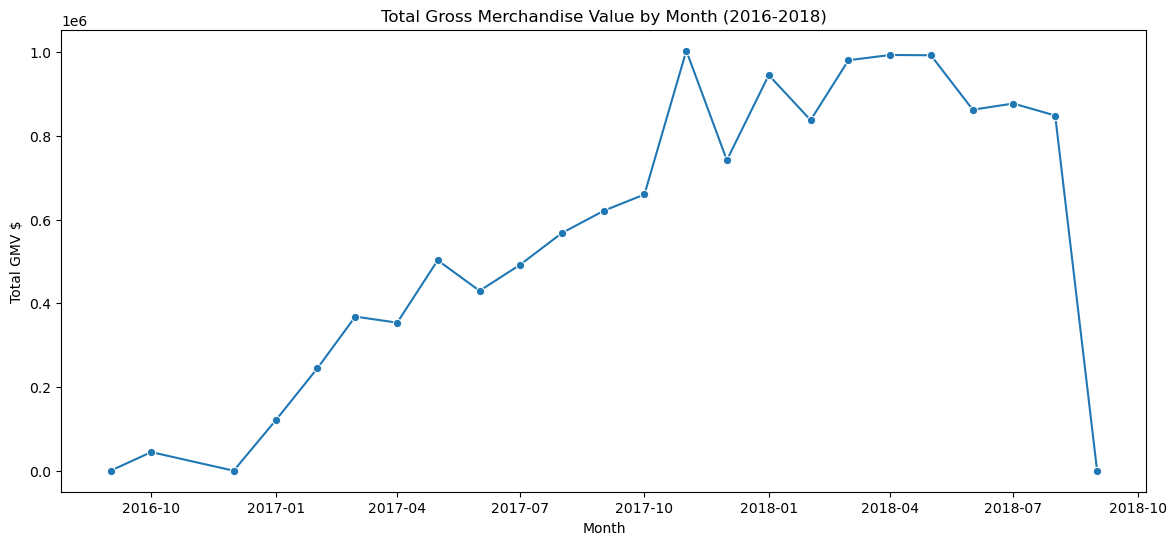

In [ ]:
# Plot the GMV data 
plt.figure(figsize=(14,6))
sns.lineplot(data=df_monthly_gmv,x='purchase_month',
             y='total_gmv', marker='o')

plt.title('Total Gross Merchandise Value by Month (2016-2018)')
plt.xlabel('Month')
plt.ylabel('Total GMV $')

# Format the y-axis 


Interpretation:
- Strong Growth: The business experienced a clear growth phase, rising from near-zero GMV in 2016 to significant sales by 2018.
- New Plateau: After the 2017 holiday surge, the business settled into a new, higher plateau of stable sales throughout 2018 (Feb-July).
- The dip in August 2018 is due to data cut off. 
- Sigh of seasonal peak in the end of the year, but only visible in November 2017 (~ +50% MoM growth) and follow by a drop in Jan 2018, which strongly indicates that Black Friday is the most critical sales period.

#### 3.3 Total Orders vs. Average Order Value (AOV)

In [14]:
# Query the monthly total orders and AOV
query_monthly_order ="""
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp,'%Y-%m-01') as purchase_month,
    COUNT(o.order_sk) as total_order,
    SUM(i.price) as total_gmv,
    (SUM(i.price) / COUNT(DISTINCT o.order_sk)) as aov
FROM fct_order_items as i 
JOIN fct_orders as o 
ON o.order_sk = i.order_sk
WHERE o.order_status NOT IN ('canceled','unavailable')
GROUP BY 1
ORDER BY 1 ASC;
"""

# Run the query 
df_monthly_order = pd.read_sql(query_monthly_order,engine)
df_monthly_order['purchase_month'] = pd.to_datetime(df_monthly_order['purchase_month'])

# Create Monthly Growth column 
df_monthly_order['mom_order'] = (df_monthly_order['total_order'].pct_change()*100).round(2)
df_monthly_order['mom_aov'] = (df_monthly_order['aov'].pct_change()*100).round(2)

display(df_monthly_order)

,purchase_month,total_order,total_gmv,aov,mom_order,mom_aov
0,2016-09-01,5,207.86,103.930000,NaN,NaN
1,2016-10-01,342,44507.30,153.473448,6740.00,47.67
2,2016-12-01,1,10.90,10.900000,-99.71,-92.90
3,2017-01-01,953,120098.27,152.602630,95200.00,1300.02
4,2017-02-01,1936,244959.35,142.584022,103.15,-6.57
5,2017-03-01,2975,368341.32,140.749454,53.67,-1.29
6,2017-04-01,2660,353842.98,148.861161,-10.59,5.76
7,2017-05-01,4105,502980.19,138.219343,54.32,-7.15
8,2017-06-01,3571,429916.61,134.139348,-13.01,-2.95
9,2017-07-01,4493,492287.30,124.756031,25.82,-7.00


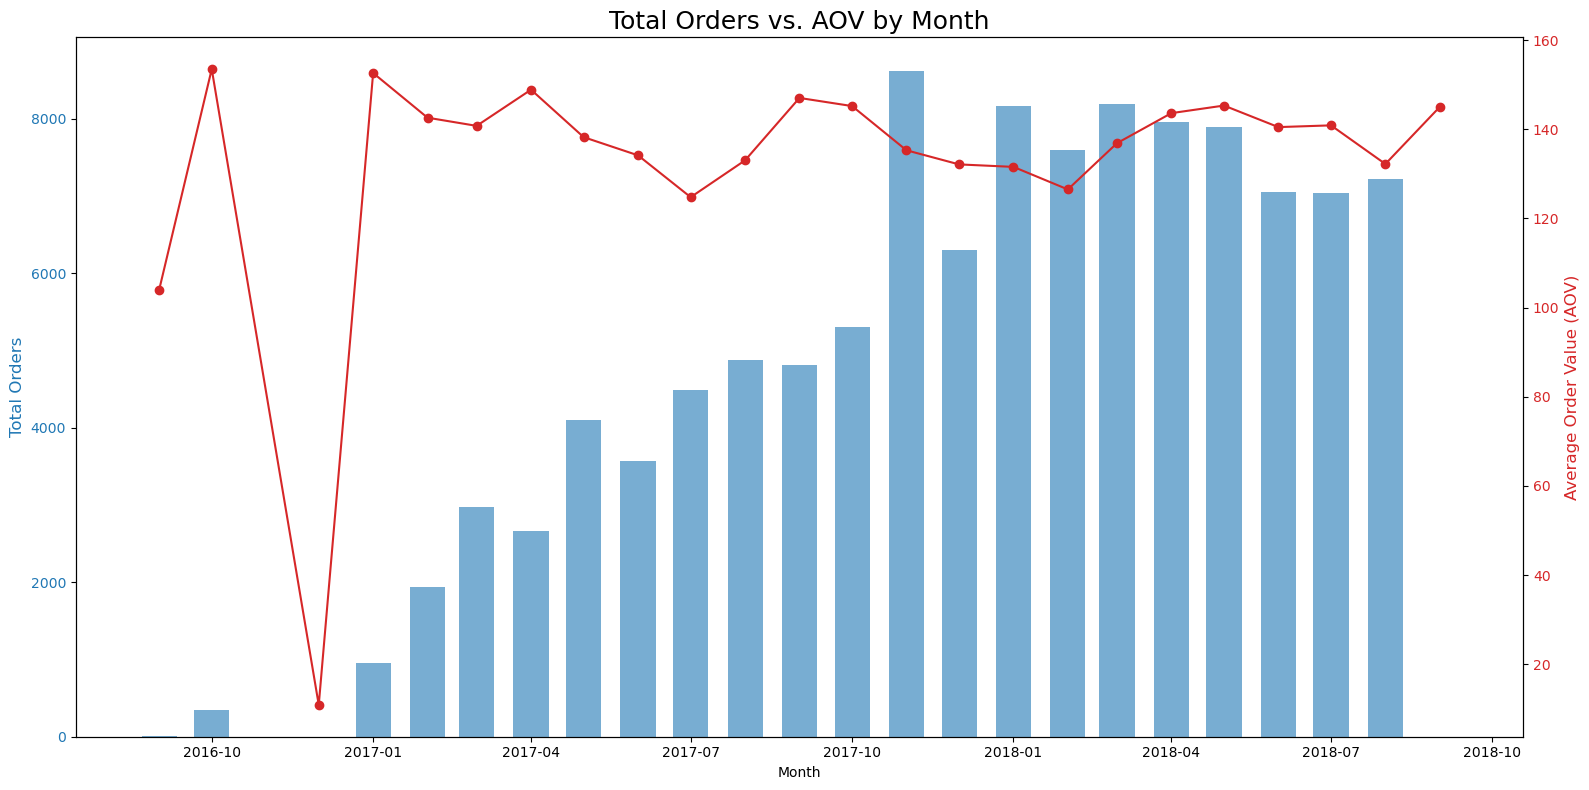

In [24]:
# Create a dual-axis chart 
# Initiate subplot 
fig, ax1 = plt.subplots(figsize=(16,8))

# Plot Total Orders 
ax1.set_title('Total Orders vs. AOV by Month',fontsize = 18)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Orders', color = 'tab:blue',fontsize = 12)

# Plot as a bar chart 
ax1.bar(df_monthly_order['purchase_month'], df_monthly_order['total_order'], alpha=0.6,label='Total Orders',width = 20)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the second Y-axis with AOV 
ax2 = ax1.twinx() 
ax2.set_ylabel('Average Order Value (AOV)', color = 'tab:red',fontsize = 12)
ax2.plot(df_monthly_order['purchase_month'], df_monthly_order['aov'], color='tab:red',marker='o',label='AOV')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

Interpretation: 
- **Total Orders**: number of orders is the main driver of GMV, total orders trend also follows GMV seasonal trend. 
- **AOV**: 
    - The AOV trend remains relatively stable over time, suggesting minimal changes in pricing strategies or customer spending behavior. 
    - AOV rather decline *(MoM ~-7%)* in the peak season **(November)** could be explained by promotional discount and seasonal price reduction.

### 4. Logistics & Operations Analysis 
<a id="section-logistics"></a>

**_"Does a longer delivery time really lead to a worse review score?"_**
#### 4.1 Calculating Delivery days

In [ ]:
# Query the delivery days, days late and review score 
query_logistic = """
SELECT 
    r.review_score,
    DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) as delivery_days, 
    DATEDIFF(o.order_delivered_customer_date, o.order_estimated_delivery_date) as days_late
FROM fct_orders as o 
JOIN fct_order_review as r
ON o.order_sk = r.order_sk
WHERE 
    o.order_status = 'delivered'
    AND o.order_delivered_customer_date IS NOT NULL
    AND o.order_estimated_delivery_date IS NOT NULL;
"""

# Execute the query to create the delays vs review df
df_logistics = pd.read_sql(query_logistic,engine)

display(df_logistics)

,review_score,delivery_days,days_late
0,1,55,36
1,4,23,-1
2,4,24,-11
3,3,31,-26
4,1,28,-23
...,...,...,...
95594,1,1,-4
95595,5,1,-5
95596,5,1,-12
95597,3,1,-4


In [34]:
# Group by review_score and calculate statistics for delivery_days
delivery_day_sum = df_logistics.groupby('review_score')['delivery_days'].agg(count='count',
                                                        median='median',
                                                        SD ='std',
                                                        percentile_50 = lambda x: x.quantile(0.50),
                                                        percentile_75 = lambda x: x.quantile(0.75),
                                                        average = 'mean',
                                                        min = 'min', max='max'
                                                        ).reset_index()

delivery_day_sum = delivery_day_sum.round(2)
display(delivery_day_sum)

,review_score,count,median,SD,percentile_50,percentile_75,average,min,max
0,1,9291,17.0,16.11,17.0,31.0,21.29,1,196
1,2,2907,13.0,12.50,13.0,22.0,16.60,1,208
2,3,7884,12.0,9.92,12.0,18.0,14.20,1,188
3,4,18861,11.0,8.30,11.0,16.0,12.25,1,195
4,5,56656,9.0,6.83,9.0,14.0,10.62,0,187


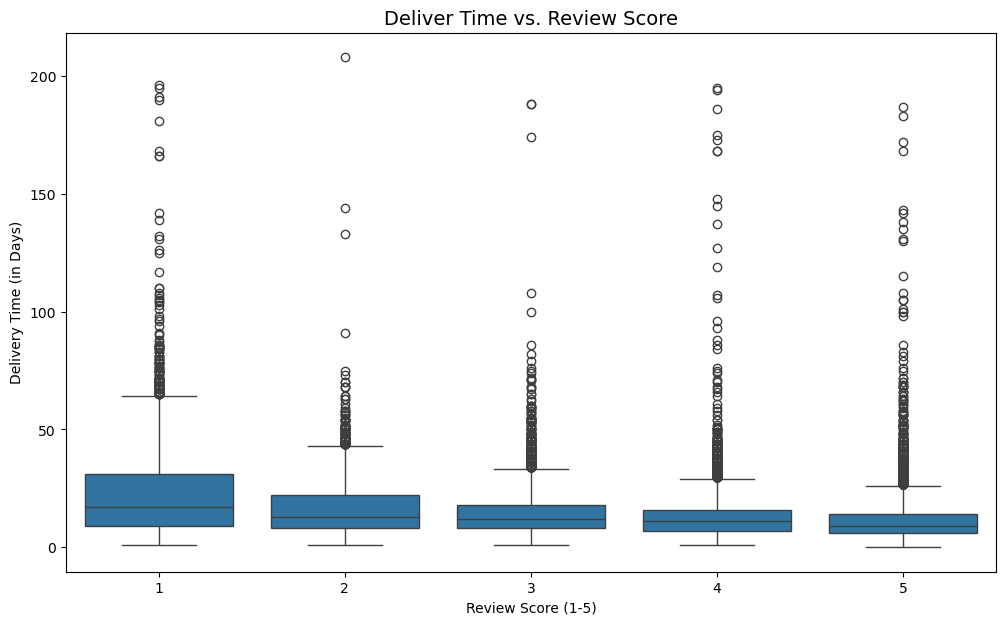

In [31]:
# Plot the data Delivery Days vs Review Score
plt.figure(figsize=(12,7))
sns.boxplot(data=df_logistics,
            x='review_score',
            y='delivery_days')

plt.title('Deliver Time vs. Review Score',fontsize=14)
plt.xlabel('Review Score (1-5)')
plt.ylabel('Delivery Time (in Days)')

plt.show()

In [35]:
# Group by review_score and calculate statistics for days_late
days_late_sum = df_logistics.groupby('review_score')['days_late'].agg(count='count',
                                                        median='median',
                                                        SD ='std',
                                                        percentile_50 = lambda x: x.quantile(0.50),
                                                        percentile_75 = lambda x: x.quantile(0.75),
                                                        average = 'mean',
                                                        min = 'min', max='max'
                                                        ).reset_index()

days_late_sum = days_late_sum.round(2)


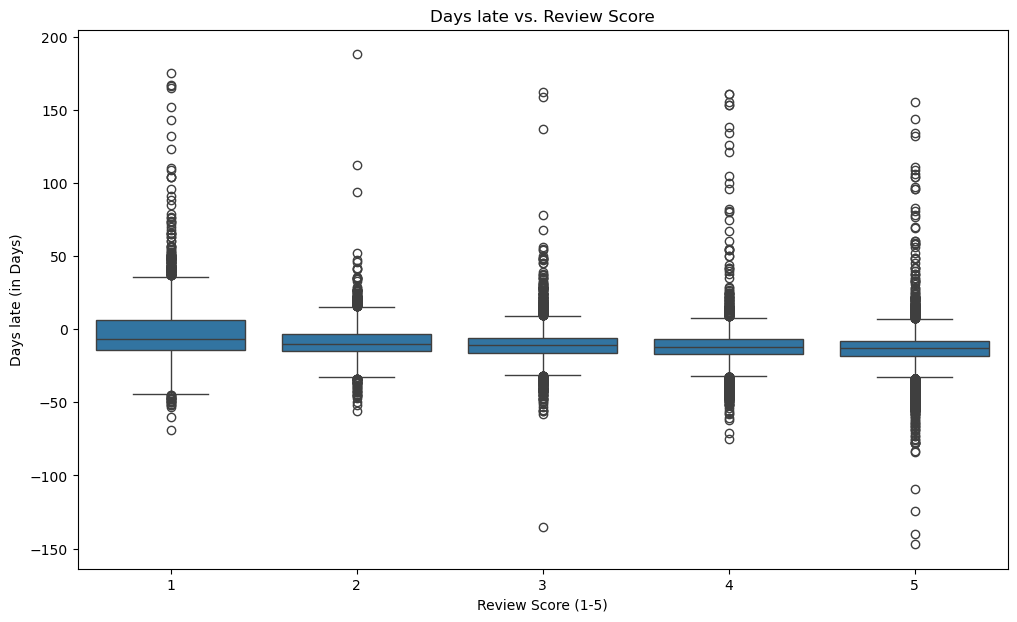

,review_score,count,median,SD,percentile_50,percentile_75,average,min,max
0,1,9291,-7.0,16.07,-7.0,6.0,-4.00,-69,175
1,2,2907,-10.0,12.67,-10.0,-3.0,-8.62,-56,188
2,3,7884,-11.0,10.37,-11.0,-6.0,-10.77,-135,162
3,4,18861,-12.0,9.05,-12.0,-7.0,-12.37,-75,161
4,5,56656,-13.0,8.15,-13.0,-8.0,-13.38,-147,155


In [36]:
# Plot the data Days late vs Review Score
plt.figure(figsize=(12,7))
sns.boxplot(data=df_logistics,
            x='review_score',
            y='days_late')

plt.title('Days late vs. Review Score')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Days late (in Days)')

plt.show()
display(days_late_sum)